### This is a gentle intoduction into Bitcoin analysis with Polars (Python).

In [1]:
import os
import polars as pl
import time
import math
import datetime as dt
import ccxt
from tqdm.notebook import tqdm, trange
from plotly.subplots import make_subplots
from typing import List, Optional
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important;}</style>"))

In [2]:
pl.Config.set_tbl_cols(100)

polars.config.Config

#### Getting hourly bitcoin data for 2023 with ccxt library

In [3]:
EXCHANGE = ccxt.binanceus()
SYMBOL = 'BTC/USDT'
TIMEFRAME = '1h'

In [4]:
# CCXT limits the number of candles per request to 1000. 


def get_btc_data_2023() -> pl.DataFrame :
    df = pl.DataFrame()
    start_timestamp = int(dt.datetime(2023, 1, 1).timestamp()) * 1000 
    total_hours = 365 * 24 # 8760
    num_of_thouands= math.floor(total_hours / 1000) # 8
    reminder = total_hours % 1000
    
    for n in range(num_of_thouands):
        ohlcv = EXCHANGE.fetch_ohlcv(SYMBOL, TIMEFRAME, start_timestamp, limit=1000)
        ohlcv_df = pl.DataFrame(ohlcv).transpose()
        ohlcv_df.columns = ["timestamp", "open", "high", "low", "close", "volume"]
        df = pl.concat([df, ohlcv_df])
        start_timestamp = int(ohlcv_df.tail(1)["timestamp"].item())
        # Pause to not abuse API rates
        time.sleep(0.5)
        
    ohlcv = EXCHANGE.fetch_ohlcv(SYMBOL, TIMEFRAME, start_timestamp, limit=reminder)
    ohlcv_df = pl.DataFrame(ohlcv).transpose()
    ohlcv_df.columns = ["timestamp", "open", "high", "low", "close", "volume"]
    df = pl.concat([df, ohlcv_df])
    return df
        

In [5]:
btc = get_btc_data_2023()

In [6]:
btc

timestamp,open,high,low,close,volume
f64,f64,f64,f64,f64,f64
1.6725e12,16522.7,16527.99,16511.38,16527.99,7.013511
1.6726e12,16532.16,16547.21,16530.46,16539.14,7.367468
1.6726e12,16541.2,16542.58,16497.67,16528.14,27.675994
1.6726e12,16528.04,16532.56,16508.11,16512.54,10.317055
1.6726e12,16513.58,16541.01,16506.31,16536.91,7.449507
1.6726e12,16536.36,16554.4,16532.7,16548.68,29.813678
1.6726e12,16549.78,16555.37,16543.03,16550.51,3.261172
1.6726e12,16555.97,16569.03,16549.34,16561.92,8.550674
1.6726e12,16563.21,16566.58,16539.0,16548.08,10.9209


#### Let's convert unix epoch timestamp into a "human readable" format

In [7]:
btc = btc.with_columns(
    pl.from_epoch(pl.col("timestamp"),time_unit="ms")
)

In [8]:
btc

timestamp,open,high,low,close,volume
datetime[ms],f64,f64,f64,f64,f64
2023-01-01 05:00:00,16522.7,16527.99,16511.38,16527.99,7.013511
2023-01-01 06:00:00,16532.16,16547.21,16530.46,16539.14,7.367468
2023-01-01 07:00:00,16541.2,16542.58,16497.67,16528.14,27.675994
2023-01-01 08:00:00,16528.04,16532.56,16508.11,16512.54,10.317055
2023-01-01 09:00:00,16513.58,16541.01,16506.31,16536.91,7.449507
2023-01-01 10:00:00,16536.36,16554.4,16532.7,16548.68,29.813678
2023-01-01 11:00:00,16549.78,16555.37,16543.03,16550.51,3.261172
2023-01-01 12:00:00,16555.97,16569.03,16549.34,16561.92,8.550674
2023-01-01 13:00:00,16563.21,16566.58,16539.0,16548.08,10.9209


In [9]:
# Create a new column "usd_volume"

btc = btc.with_columns(
    (pl.col("volume") * pl.col("close")).alias("usd_volume")
)

In [10]:
# Create a new column "is_bullish" to identify the price direction

btc = btc.with_columns(
    pl.when(
        pl.col("close") > pl.col("open")
    )
    .then(1)
    .when(
        pl.col("close") < pl.col("open")
    )
    .then(-1)
    .otherwise(0)
    .alias("is_bullish")
)

In [11]:
btc.head()

timestamp,open,high,low,close,volume,usd_volume,is_bullish
datetime[ms],f64,f64,f64,f64,f64,f64,i32
2023-01-01 05:00:00,16522.7,16527.99,16511.38,16527.99,7.013511,115919.239673,1
2023-01-01 06:00:00,16532.16,16547.21,16530.46,16539.14,7.367468,121851.584698,1
2023-01-01 07:00:00,16541.2,16542.58,16497.67,16528.14,27.675994,457432.703471,-1
2023-01-01 08:00:00,16528.04,16532.56,16508.11,16512.54,10.317055,170360.78337,-1
2023-01-01 09:00:00,16513.58,16541.01,16506.31,16536.91,7.449507,123191.826803,1


In [12]:
# Check how many states (bullish, bearish, neutral) are present.
btc["is_bullish"].unique()

is_bullish
i32
-1
0
1


In [13]:
# Double check if a neutral state is correct (open == close)

btc.filter(pl.col("is_bullish") == 0)

timestamp,open,high,low,close,volume,usd_volume,is_bullish
datetime[ms],f64,f64,f64,f64,f64,f64,i32
2023-08-06 04:00:00,29079.99,29080.0,29057.64,29079.99,1.41568,41167.960243,0
2023-08-13 10:00:00,29398.99,29399.0,29390.01,29398.99,0.13796,4055.88466,0
2023-08-17 14:00:00,28395.0,28455.0,28308.55,28395.0,30.83384,875526.8868,0
2023-09-19 20:00:00,27185.0,27225.0,27114.68,27185.0,7.76608,211120.8848,0


In [32]:
# Get bullish, bearish, and neutral directions in %. 

is_bullish = btc["is_bullish"].unique_counts() / btc["is_bullish"].unique_counts().sum() * 100
is_bullish.to_frame().insert_column(1, pl.Series("direction", ["bullish", "bearish", "neutral"] ))

is_bullish,direction
f64,str
51.324201,"""bullish"""
48.630137,"""bearish"""
0.045662,"""neutral"""


In [33]:
# The data came in UTC timezone, need to convert to NY timezone

btc = btc.with_columns(
    pl.col("timestamp").dt.replace_time_zone("UTC").dt.convert_time_zone("America/New_York").alias("NY_timezone")
)

In [34]:
btc.head()

timestamp,open,high,low,close,volume,usd_volume,is_bullish,NY_timezone
datetime[ms],f64,f64,f64,f64,f64,f64,i32,"datetime[ms, America/New_York]"
2023-01-01 05:00:00,16522.7,16527.99,16511.38,16527.99,7.013511,115919.239673,1,2023-01-01 00:00:00 EST
2023-01-01 06:00:00,16532.16,16547.21,16530.46,16539.14,7.367468,121851.584698,1,2023-01-01 01:00:00 EST
2023-01-01 07:00:00,16541.2,16542.58,16497.67,16528.14,27.675994,457432.703471,-1,2023-01-01 02:00:00 EST
2023-01-01 08:00:00,16528.04,16532.56,16508.11,16512.54,10.317055,170360.78337,-1,2023-01-01 03:00:00 EST
2023-01-01 09:00:00,16513.58,16541.01,16506.31,16536.91,7.449507,123191.826803,1,2023-01-01 04:00:00 EST


In [40]:
# Total capitalization in 2023

print(f"Total capitalization of BTC in 2023 is {(btc['usd_volume'].sum() / 1_000_000_000)} trillions")

Total capitalization of BTC in 2023 is 8.838656384659776 trillions


#### **Let's analyze trading activities in different timeframes**

In [42]:
# let's extract months and calclulate usd volume per month

month_df = btc.with_columns(
    pl.col("NY_timezone").dt.month().alias("month")
).lazy().group_by("month").agg(pl.col("usd_volume").sum()).collect().sort("month")


In [43]:
month_df

month,usd_volume
u32,f64
1,1.3546e9
2,1.1109e9
3,2.1550e9
4,1.9924e9
5,7.8112e8
6,2.3081e8
7,1.5996e8
8,1.5873e8
9,1.3275e8


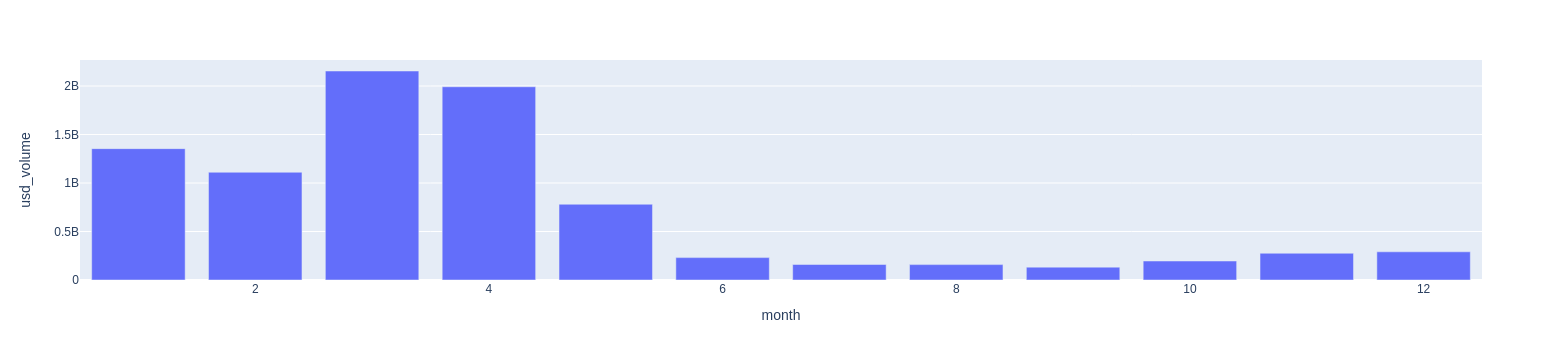

In [44]:
# Visualize monthly volumes

fig = px.bar(data_frame=month_df.to_pandas(), x="month", y="usd_volume")
fig.show()

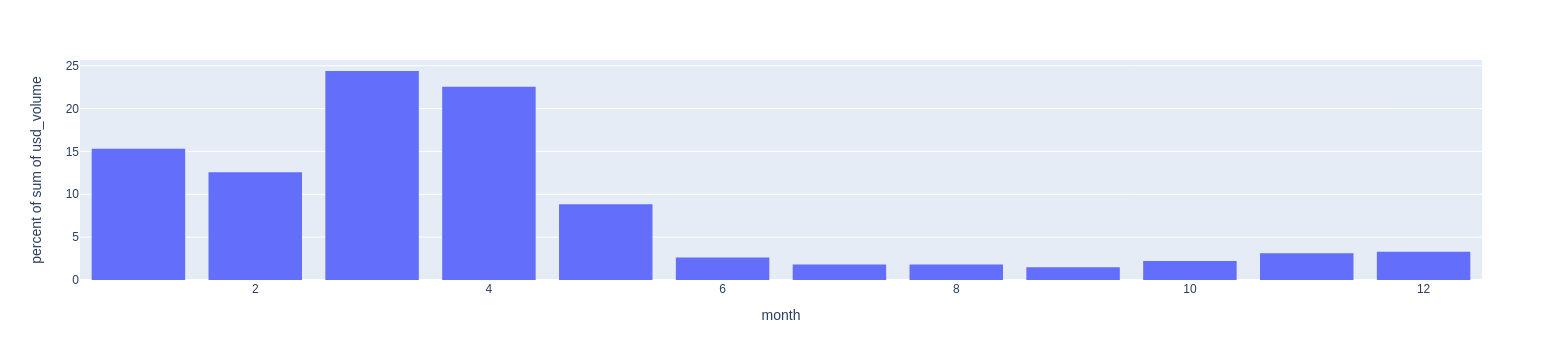

In [47]:
# Let's dissplay usd volume in % not in dollars

fig = px.histogram(data_frame=month_df.to_pandas(), x="month", y="usd_volume", nbins=12, histnorm="percent")
fig.update_layout(bargap=0.2)
fig.show()

In [48]:
# Let's check weekly volumes

week_df = btc.with_columns(
    pl.col("NY_timezone").dt.week().alias("week")
).lazy().group_by("week").agg(pl.col("usd_volume").sum()).collect().sort("week")
week_df

week,usd_volume
u32,f64
1,1.0517e8
2,5.3599e8
3,3.8950e8
4,2.6213e8
5,2.2193e8
6,2.0092e8
7,3.5135e8
8,3.1068e8
9,2.7170e8


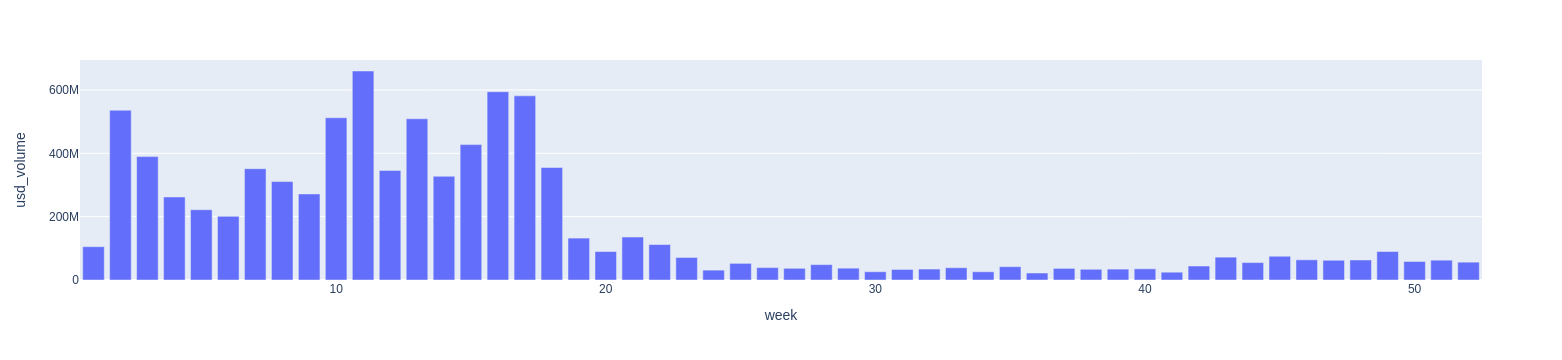

In [49]:
fig = px.bar(data_frame=week_df.to_pandas(), x="week", y="usd_volume")
fig.show()

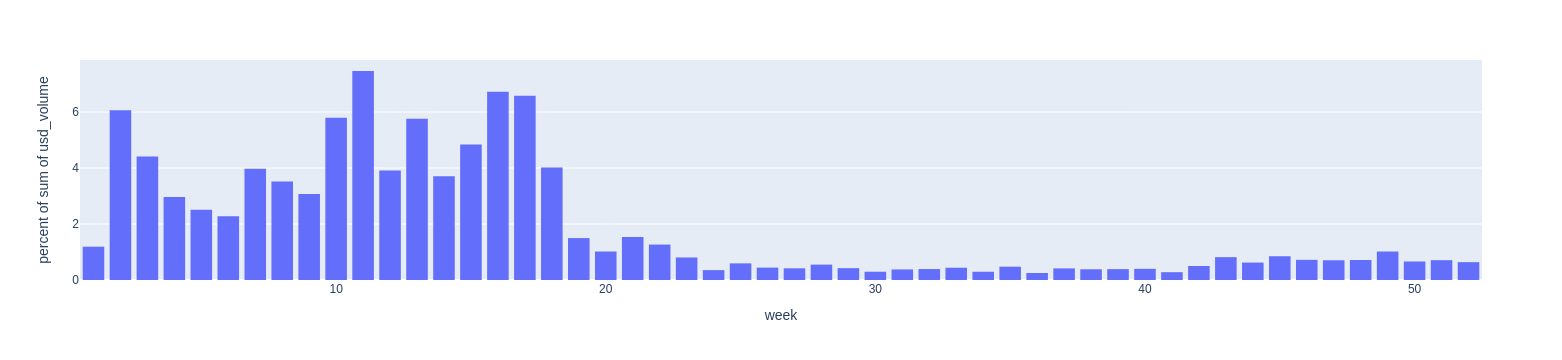

In [50]:
# Normalized plot

fig = px.histogram(data_frame=week_df.to_pandas(), x="week", y="usd_volume", nbins=52, histnorm="percent")
fig.update_layout(bargap=0.2)
fig.show()

In [52]:
# Calculate a daily volume

day_of_year_df = btc.with_columns(
    pl.col("NY_timezone").dt.ordinal_day().alias("day_of_year")
).lazy().group_by("day_of_year").agg(pl.col("usd_volume").sum()).collect().sort("day_of_year")
day_of_year_df

day_of_year,usd_volume
u32,f64
1,5.7245e6
2,1.1907e7
3,1.2407e7
4,2.5458e7
5,1.2152e7
6,2.0663e7
7,4.5466e6
8,9.9918e6
9,2.9658e7


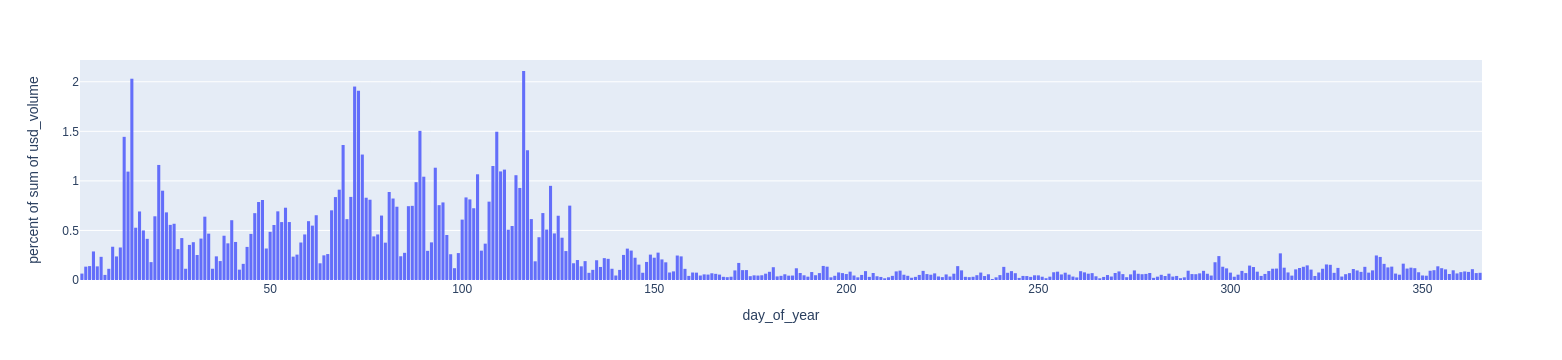

In [53]:
fig = px.histogram(data_frame=day_of_year_df.to_pandas(), x="day_of_year", y="usd_volume", nbins=365, histnorm="percent" )
fig.update_layout(bargap=0.2)
fig.show()

#### **Now let's take a look at trading distibution among days in a month**

In [55]:
day_df = btc.with_columns(
    pl.col("NY_timezone").dt.day().alias("day")
).lazy().group_by("day").agg(pl.col("usd_volume").sum()).collect().sort("day")
day_df

day,usd_volume
u32,f64
1,2.4163e8
2,2.6154e8
3,3.1736e8
4,2.2334e8
5,2.2761e8
6,1.9840e8
7,2.1715e8
8,2.3984e8
9,2.5051e8


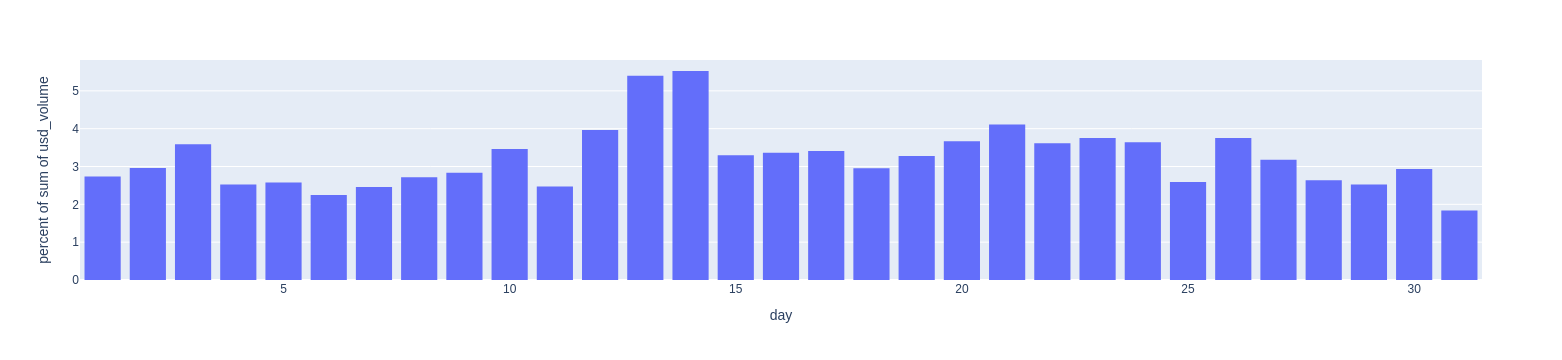

In [56]:
# Plot the results

fig = px.histogram(data_frame=day_df.to_pandas(), x="day", y="usd_volume",  nbins=31, histnorm="percent")
fig.update_layout(bargap=0.2)
fig.show()

#### **Now let's take a look at the most/least traded days of the week**

In [69]:
# Get the df with corresponding weekdays

weekday_df = btc.with_columns(
    pl.col("NY_timezone").dt.weekday().alias("weekday")
).lazy().group_by("weekday").agg(pl.col("usd_volume").sum()).collect().sort("weekday")
weekday_df

weekday,usd_volume
u32,f64
1,1.3274e9
2,1.3609e9
3,1.6496e9
4,1.4774e9
5,1.3759e9
6,7.3087e8
7,9.1658e8


In [70]:
# Convert weekdays numbers into weekdays names

weekday_df = weekday_df.with_columns(
    pl.col("weekday")
    .replace(
        {
            1: "Monday",
            2: "Tuesday",
            3: "Wednesday",
            4: "Thursday",
            5: "Friday",
            6: "Saturday",
            7: "Sunday"
        }
    )
    
)

In [71]:
weekday_df

weekday,usd_volume
str,f64
"""Monday""",1.3274e9
"""Tuesday""",1.3609e9
"""Wednesday""",1.6496e9
"""Thursday""",1.4774e9
"""Friday""",1.3759e9
"""Saturday""",7.3087e8
"""Sunday""",9.1658e8


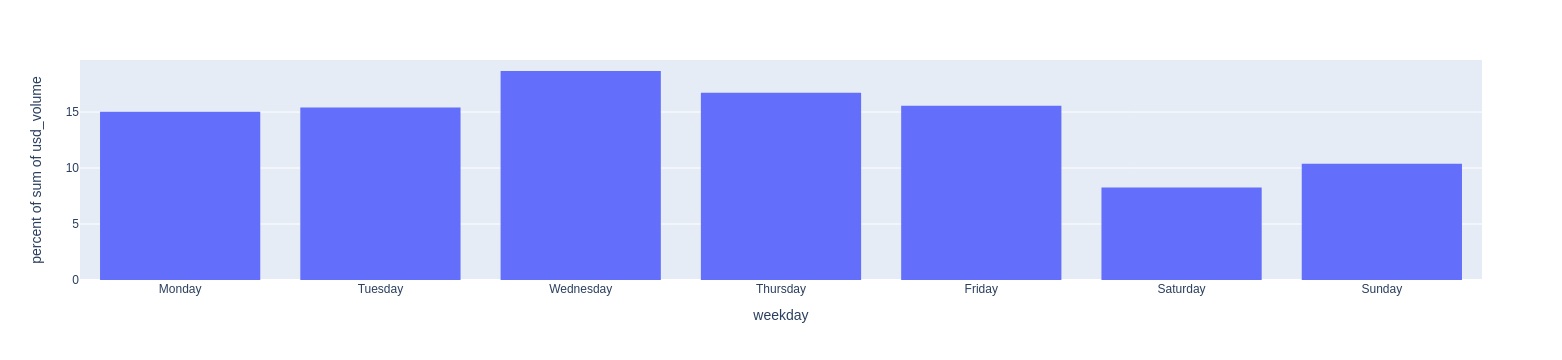

In [31]:
# Plot the results

fig = px.histogram(data_frame=weekday_df.to_pandas(), x="weekday", y="usd_volume", nbins=7, histnorm="percent")
fig.update_layout(bargap=0.2)
fig.show()

#### **Now let's take a look at the most traded hours during the day**

In [73]:
# Extract hours from df

hours = btc.with_columns(
    pl.col("NY_timezone").dt.hour().alias("hours")
).lazy().group_by("hours").agg(pl.col("usd_volume").sum()).collect().sort("hours")
hours

hours,usd_volume
u32,f64
0,1.9661e8
1,2.0365e8
2,2.3576e8
3,2.4487e8
4,3.0644e8
5,2.6102e8
6,2.5016e8
7,2.8334e8
8,4.3983e8


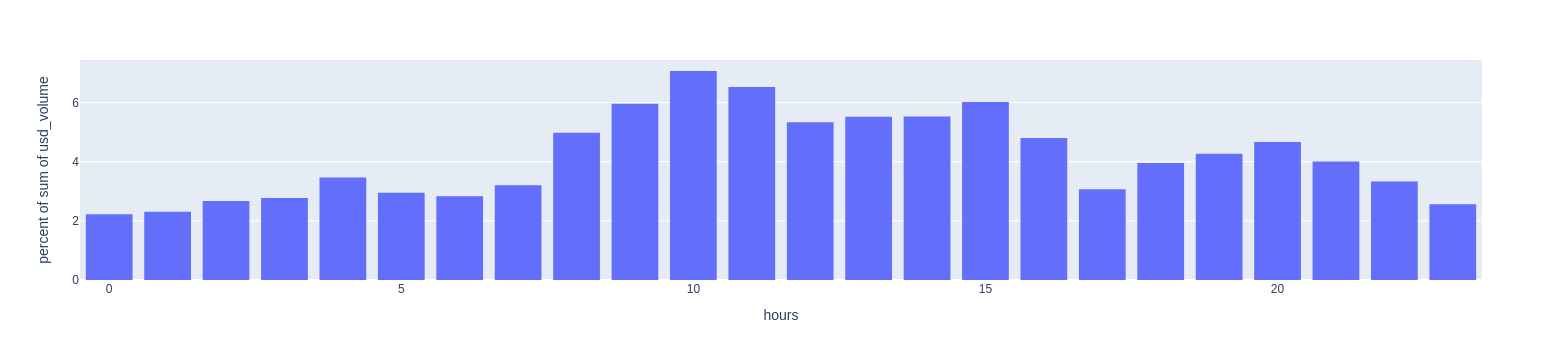

In [74]:
# Plot the results

fig = px.histogram(data_frame=hours.to_pandas(), x="hours", y="usd_volume", histnorm="percent", nbins=24)
fig.update_layout(bargap=0.2)
fig.show()

In [75]:
# Convert to LA timezone

la_df = btc.with_columns(
    pl.col("timestamp").dt.replace_time_zone("UTC").dt.convert_time_zone("America/Los_Angeles").alias("LA_timezone")
)
la_df

timestamp,open,high,low,close,volume,usd_volume,is_bullish,NY_timezone,LA_timezone
datetime[ms],f64,f64,f64,f64,f64,f64,i32,"datetime[ms, America/New_York]","datetime[ms, America/Los_Angeles]"
2023-01-01 05:00:00,16522.7,16527.99,16511.38,16527.99,7.013511,115919.239673,1,2023-01-01 00:00:00 EST,2022-12-31 21:00:00 PST
2023-01-01 06:00:00,16532.16,16547.21,16530.46,16539.14,7.367468,121851.584698,1,2023-01-01 01:00:00 EST,2022-12-31 22:00:00 PST
2023-01-01 07:00:00,16541.2,16542.58,16497.67,16528.14,27.675994,457432.703471,-1,2023-01-01 02:00:00 EST,2022-12-31 23:00:00 PST
2023-01-01 08:00:00,16528.04,16532.56,16508.11,16512.54,10.317055,170360.78337,-1,2023-01-01 03:00:00 EST,2023-01-01 00:00:00 PST
2023-01-01 09:00:00,16513.58,16541.01,16506.31,16536.91,7.449507,123191.826803,1,2023-01-01 04:00:00 EST,2023-01-01 01:00:00 PST
2023-01-01 10:00:00,16536.36,16554.4,16532.7,16548.68,29.813678,493377.016845,1,2023-01-01 05:00:00 EST,2023-01-01 02:00:00 PST
2023-01-01 11:00:00,16549.78,16555.37,16543.03,16550.51,3.261172,53974.059798,1,2023-01-01 06:00:00 EST,2023-01-01 03:00:00 PST
2023-01-01 12:00:00,16555.97,16569.03,16549.34,16561.92,8.550674,141615.578734,1,2023-01-01 07:00:00 EST,2023-01-01 04:00:00 PST
2023-01-01 13:00:00,16563.21,16566.58,16539.0,16548.08,10.9209,180719.926872,-1,2023-01-01 08:00:00 EST,2023-01-01 05:00:00 PST


In [77]:
# Extract LA timezone hours

la_hours = la_df.with_columns(
    pl.col("LA_timezone").dt.hour().alias("hours")
).lazy().group_by("hours").agg(pl.col("usd_volume").sum()).collect().sort("hours")
la_hours

hours,usd_volume
u32,f64
0,2.4475e8
1,3.0633e8
2,2.6043e8
3,2.5016e8
4,2.8334e8
5,4.3983e8
6,5.2662e8
7,6.2462e8
8,5.7699e8


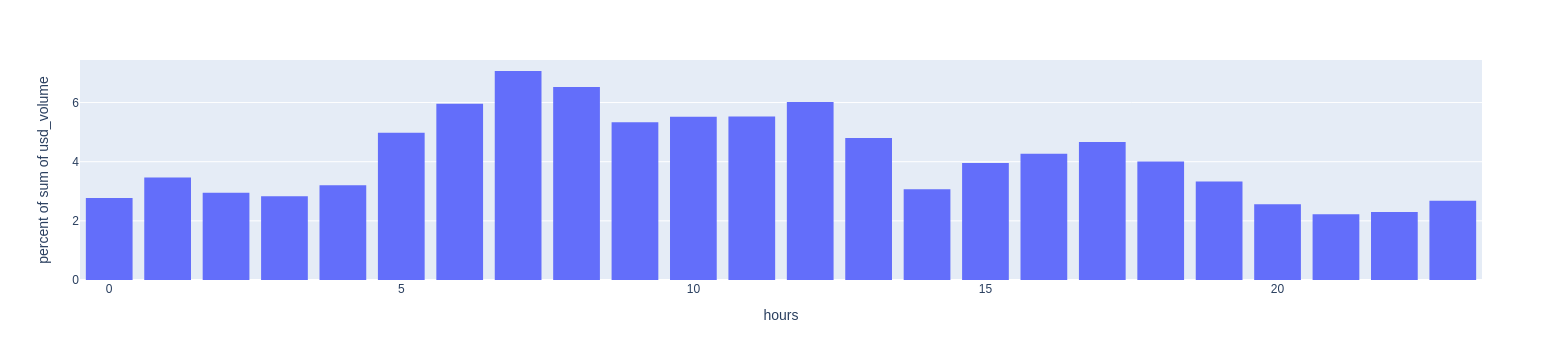

In [78]:
fig = px.histogram(data_frame=la_hours.to_pandas(), x="hours", y="usd_volume", histnorm="percent", nbins=24)
fig.update_layout(bargap=0.2)
fig.show()

In [79]:
daily_df = btc.set_sorted("NY_timezone").group_by_dynamic("NY_timezone", every="1d").agg(
    [
        pl.col("open").first().alias("open_1d"),
        pl.col("high").max().alias("high_1d"),
        pl.col("low").min().alias("low_1d"),
        pl.col("close").last().alias("close_1d"),
        pl.col("usd_volume").sum().alias("usd_volume_1d"),
    ]
)
daily_df

NY_timezone,open_1d,high_1d,low_1d,close_1d,usd_volume_1d
"datetime[ms, America/New_York]",f64,f64,f64,f64,f64
2023-01-01 00:00:00 EST,16522.7,16704.57,16497.67,16637.79,6.3087e6
2023-01-02 00:00:00 EST,16642.38,16785.92,16621.09,16689.54,1.1458e7
2023-01-03 00:00:00 EST,16688.92,16907.55,16604.95,16863.45,1.6451e7
2023-01-04 00:00:00 EST,16866.03,16984.83,16766.82,16835.52,2.1746e7
2023-01-05 00:00:00 EST,16833.45,16876.47,16756.91,16824.63,1.2547e7
2023-01-06 00:00:00 EST,16821.99,17030.14,16683.74,16937.57,1.9439e7
2023-01-07 00:00:00 EST,16935.79,16954.64,16908.62,16936.21,4.5028e6
2023-01-08 00:00:00 EST,16936.11,17251.21,16914.8,17223.78,1.9023e7
2023-01-09 00:00:00 EST,17225.75,17395.51,17131.79,17222.32,2.2926e7


In [80]:
# Create a new column "pct_change"

daily_df = daily_df.with_columns(
    (pl.col("close_1d").pct_change()* 100).alias("pct_change")
)
daily_df

NY_timezone,open_1d,high_1d,low_1d,close_1d,usd_volume_1d,pct_change
"datetime[ms, America/New_York]",f64,f64,f64,f64,f64,f64
2023-01-01 00:00:00 EST,16522.7,16704.57,16497.67,16637.79,6.3087e6,null
2023-01-02 00:00:00 EST,16642.38,16785.92,16621.09,16689.54,1.1458e7,0.311039
2023-01-03 00:00:00 EST,16688.92,16907.55,16604.95,16863.45,1.6451e7,1.04203
2023-01-04 00:00:00 EST,16866.03,16984.83,16766.82,16835.52,2.1746e7,-0.165624
2023-01-05 00:00:00 EST,16833.45,16876.47,16756.91,16824.63,1.2547e7,-0.064685
2023-01-06 00:00:00 EST,16821.99,17030.14,16683.74,16937.57,1.9439e7,0.671278
2023-01-07 00:00:00 EST,16935.79,16954.64,16908.62,16936.21,4.5028e6,-0.008029
2023-01-08 00:00:00 EST,16936.11,17251.21,16914.8,17223.78,1.9023e7,1.69796
2023-01-09 00:00:00 EST,17225.75,17395.51,17131.79,17222.32,2.2926e7,-0.008477


In [81]:
# Add "is_bullish" column

daily_df = daily_df.with_columns(
    pl.when(
        pl.col("close_1d") >= pl.col("open_1d")
    )
    .then(1)
    .otherwise(0)
    .alias("is_bullish")
)

In [82]:
# Retrieve the max value

daily_df.filter(pl.col("pct_change") == pl.col("pct_change").max())

NY_timezone,open_1d,high_1d,low_1d,close_1d,usd_volume_1d,pct_change,is_bullish
"datetime[ms, America/New_York]",f64,f64,f64,f64,f64,f64,i32
2023-02-15 00:00:00 EST,22085.89,24896.86,22080.86,24639.55,7.2271e7,11.617289,1


In [83]:
# Retreive the min value

daily_df.filter(pl.col("pct_change") == pl.col("pct_change").min())

NY_timezone,open_1d,high_1d,low_1d,close_1d,usd_volume_1d,pct_change,is_bullish
"datetime[ms, America/New_York]",f64,f64,f64,f64,f64,f64,i32
2023-03-09 00:00:00 EST,21739.54,21832.13,19781.63,19876.01,9.7061e7,-8.585238,0


**Now let's plot pct_change vs volume**

In [86]:
def plot_daily_df(df: pl.DataFrame):
    fig = go.Figure()
    
    fig = make_subplots(
        rows=2, cols=1,
        row_heights=[0.7, 0.3],
        shared_xaxes=True,
        shared_yaxes=True,
        vertical_spacing=0.01
       )
    
    fig.add_trace(
            go.Scatter(
                    x=df["NY_timezone"],
                    y=df["pct_change"],
                    mode='lines',
                    name="PCT_CHANGE",
                ), row=1, col=1)
    
    
    # VOLUME        
     
    bullish_df = df.filter(pl.col("is_bullish") == 1)
    bearish_df = df.filter(pl.col("is_bullish") == 0)

    fig.add_trace(
       go.Bar(
           x=bullish_df["NY_timezone"],
           y=bullish_df["usd_volume_1d"],
           marker_color="green",
           name="bullish"
       ),
        row=2, col=1,
    )

    fig.add_trace(
       go.Bar(
           x=bearish_df["NY_timezone"],
           y=bearish_df["usd_volume_1d"],
           marker_color="red",
           name="bearish"
       ),
        row=2, col=1
    )
    
    fig.update_layout(
        title="Relationship between pct-change and volume",
        hovermode='x unified',
        height=600,
        margin=dict(
            l=50,
            r=50,
            b=10,
            t=50
        ),
    )
    fig.update_yaxes(title_text="PCT CHANGE", row=1, col=1)
    fig.update_yaxes(title_text="VOLUME USD", row=2, col=1)
    fig.update(
        layout_xaxis_rangeslider_visible=False,
    )
    fig.show()

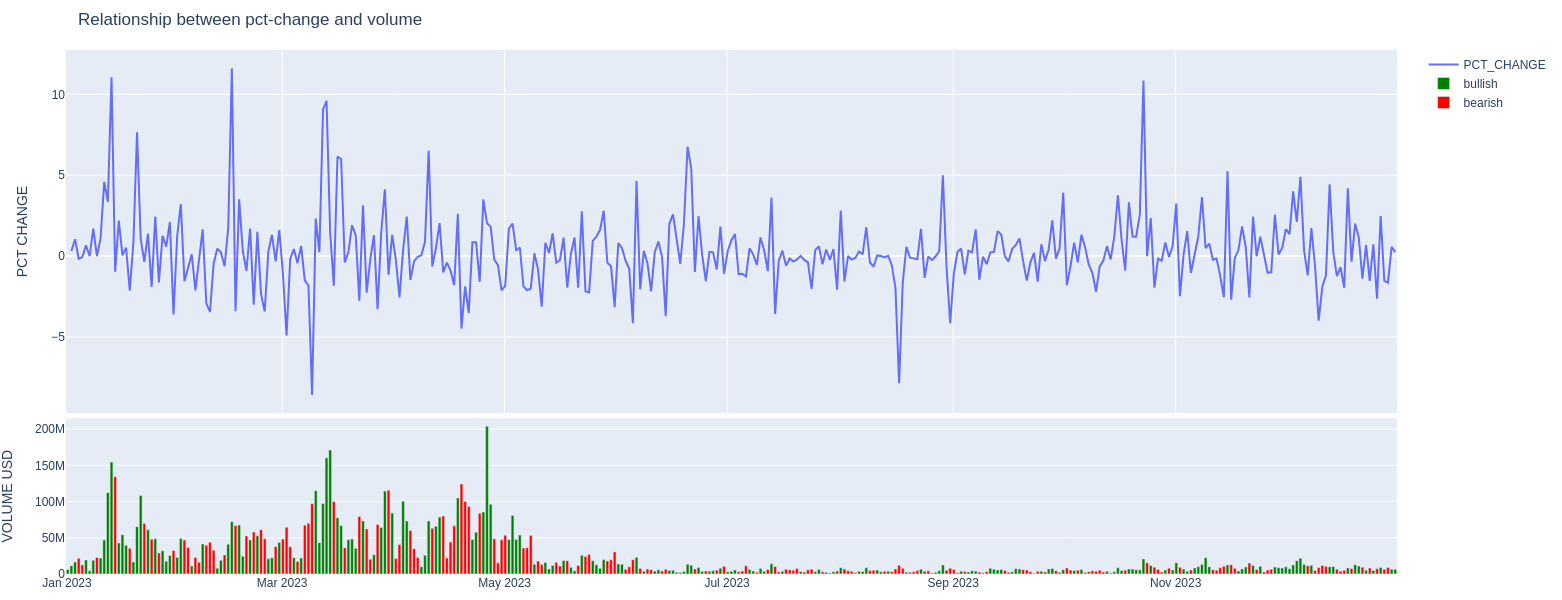

In [87]:
plot_daily_df(daily_df)

#### **There are a lot of other things to explore further. This is just a basic analysis to get started.**